In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

#Fire Dataset

In [ ]:
df = pd.read_csv('CA_Weather_Fire_Dataset.csv')
df.head()

,DATE,PRECIPITATION,MAX_TEMP,MIN_TEMP,AVG_WIND_SPEED,FIRE_START_DAY,YEAR,TEMP_RANGE,WIND_TEMP_RATIO,MONTH,SEASON,LAGGED_PRECIPITATION,LAGGED_AVG_WIND_SPEED,DAY_OF_YEAR
0,1984-01-01,0.0,79.0,51.0,4.70,False,1984,28.0,0.059494,1,Winter,0.0,4.700,1
1,1984-01-02,0.0,71.0,46.0,5.59,False,1984,25.0,0.078732,1,Winter,0.0,5.145,2
2,1984-01-03,0.0,70.0,47.0,5.37,False,1984,23.0,0.076714,1,Winter,0.0,5.220,3
3,1984-01-04,0.0,76.0,45.0,4.70,False,1984,31.0,0.061842,1,Winter,0.0,5.090,4
4,1984-01-05,0.0,74.0,49.0,5.14,False,1984,25.0,0.069459,1,Winter,0.0,5.100,5


## Drop the data before 2015

In [ ]:
df = df[df['YEAR'] >= 2015].copy()
df = df.reset_index(drop=True)
print(f"New dataset shape: {df.shape}")
print(f"Earliest year in data: {df['YEAR'].min()}")

New dataset shape: (3665, 14)
Earliest year in data: 2015


In [ ]:
# List of columns to drop # drop 'DATE' and 'YEAR' because they are just ID labels, not weather data
drop_cols = [
    'DATE',             #  not predictive
    'YEAR',             #  filtered by it, now it's just noise
]

df = df.drop(columns=drop_cols)

In [ ]:
df.head()

,PRECIPITATION,MAX_TEMP,MIN_TEMP,AVG_WIND_SPEED,FIRE_START_DAY,TEMP_RANGE,WIND_TEMP_RATIO,MONTH,SEASON,LAGGED_PRECIPITATION,LAGGED_AVG_WIND_SPEED,DAY_OF_YEAR
0,0.0,57.0,36.0,5.14,False,21.0,0.090175,1,Winter,0.31,5.527143,1
1,0.0,56.0,38.0,4.25,False,18.0,0.075893,1,Winter,0.31,5.400000,2
2,0.0,59.0,42.0,5.14,False,17.0,0.087119,1,Winter,0.31,5.400000,3
3,0.0,61.0,42.0,4.70,False,19.0,0.077049,1,Winter,0.31,5.400000,4
4,0.0,79.0,50.0,5.59,False,29.0,0.070759,1,Winter,0.31,5.622857,5


## EDA

In [ ]:
df.info()
df.isna().sum()
df.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3665 entries, 0 to 3664
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PRECIPITATION          3664 non-null   float64
 1   MAX_TEMP               3664 non-null   float64
 2   MIN_TEMP               3664 non-null   float64
 3   AVG_WIND_SPEED         3656 non-null   float64
 4   FIRE_START_DAY         3665 non-null   bool   
 5   TEMP_RANGE             3664 non-null   float64
 6   WIND_TEMP_RATIO        3656 non-null   float64
 7   MONTH                  3665 non-null   int64  
 8   SEASON                 3665 non-null   object 
 9   LAGGED_PRECIPITATION   3665 non-null   float64
 10  LAGGED_AVG_WIND_SPEED  3665 non-null   float64
 11  DAY_OF_YEAR            3665 non-null   int64  
dtypes: bool(1), float64(8), int64(2), object(1)
memory usage: 318.7+ KB


,0
PRECIPITATION,109
MAX_TEMP,51
MIN_TEMP,40
AVG_WIND_SPEED,74
FIRE_START_DAY,2
TEMP_RANGE,36
WIND_TEMP_RATIO,1061
MONTH,12
SEASON,4
LAGGED_PRECIPITATION,351


 Minimal Missingness: The dataset contains a negligible amount of missing data (approx. 10 rows), representing only 0.27% of the total 3,665 entries, primarily affecting AVG_WIND_SPEED.


Mixed Data Types: The dataset is not purely numeric; it contains categorical text (SEASON) and boolean targets (FIRE_START_DAY), which means you cannot feed it directly into a model without encoding


Decide Execute Row Deletion: Given the insignificant volume of lost data, I will drop these rows entirely instead of imputing them. This ensures the model trains on purely observed weather conditions without the risk of bias introduced by synthetic mean/median filling.

In [ ]:
num = df._get_numeric_data()   #  only int/float columns
print(num.describe().T)
print(num.skew())
print(num.kurtosis())

                        count        mean         std        min        25%  \
PRECIPITATION          3664.0    0.033794    0.190800   0.000000   0.000000   
MAX_TEMP               3664.0   71.245906    7.463432  53.000000  66.000000   
MIN_TEMP               3664.0   57.165393    6.937413  36.000000  52.000000   
AVG_WIND_SPEED         3656.0    7.338187    2.167833   2.460000   5.820000   
TEMP_RANGE             3664.0   14.080513    5.983854   3.000000  10.000000   
WIND_TEMP_RATIO        3656.0    0.104662    0.036134   0.027640   0.081972   
MONTH                  3665.0    6.504229    3.458116   1.000000   4.000000   
LAGGED_PRECIPITATION   3665.0    0.236914    0.685507   0.000000   0.000000   
LAGGED_AVG_WIND_SPEED  3665.0    7.333201    1.367292   3.705714   6.360000   
DAY_OF_YEAR            3665.0  182.571896  105.777514   1.000000  91.000000   

                              50%         75%         max  
PRECIPITATION            0.000000    0.000000    3.120000  
MAX_TEMP  

 Extreme Sparsity: The PRECIPITATION feature is statistically problematic; with a massive skewness of 8.32 and kurtosis of 84.6, the data is heavily compressed at 0.0 (over 75% of days are dry). This "zero-inflated" distribution means a standard model might ignore rain entirely as statistical noise.

  Feature Stability: In contrast, MAX_TEMP and MIN_TEMP exhibit near-perfect normal distributions (Skewness ~0.5 and -0.07), providing reliable, stable anchors for the model that require minimal preprocessing.
  
  Decide Apply Log-Transformation: To prevent the extreme outliers in rainfall from confusing the model, I will apply a Log(x+1) transformation to PRECIPITATION. This will compress the "long tail" of storm data into a balanced range, allowing the Neural Network to effectively learn the difference between dry days, light rain, and heavy storms.

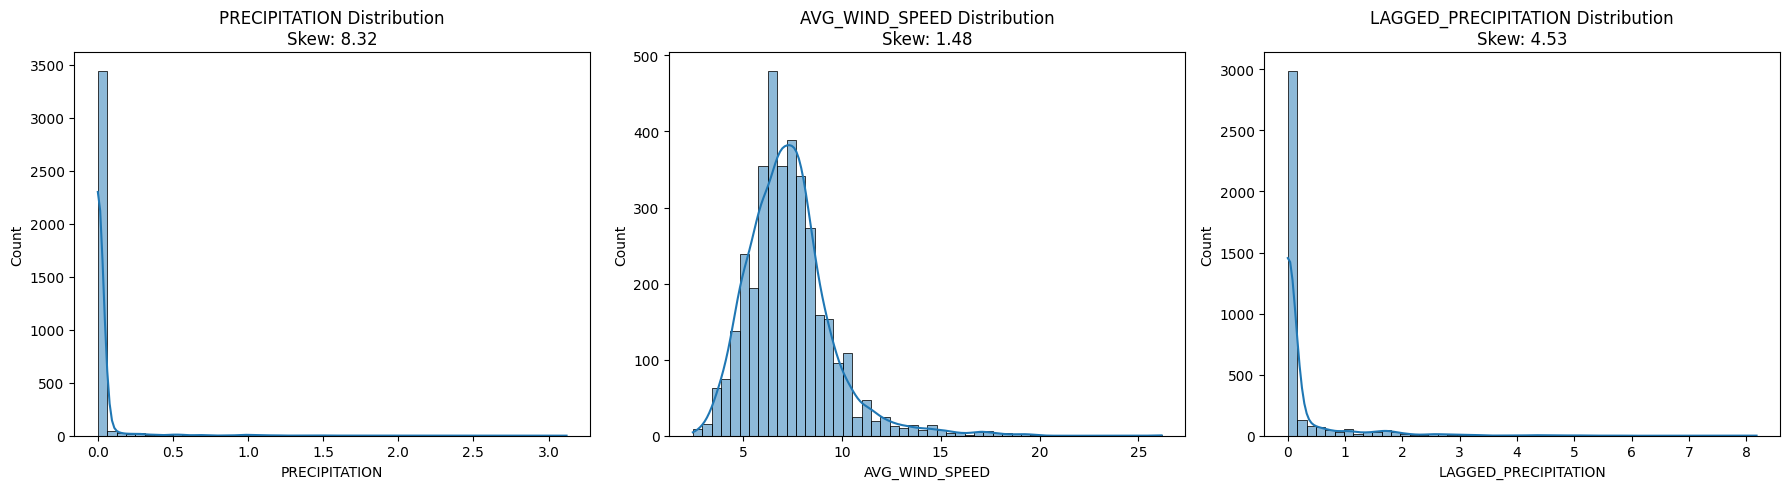

In [ ]:
cols_to_check = ['PRECIPITATION', 'AVG_WIND_SPEED', 'LAGGED_PRECIPITATION']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, col in enumerate(cols_to_check):
    sns.histplot(df[col].dropna(), bins=50, ax=axes[i], kde=True)
    axes[i].set_title(f"{col} Distribution\nSkew: {df[col].skew():.2f}")

plt.tight_layout()
plt.show()

SEASON
Spring    920
Summer    920
Winter    915
Fall      910
Name: count, dtype: int64


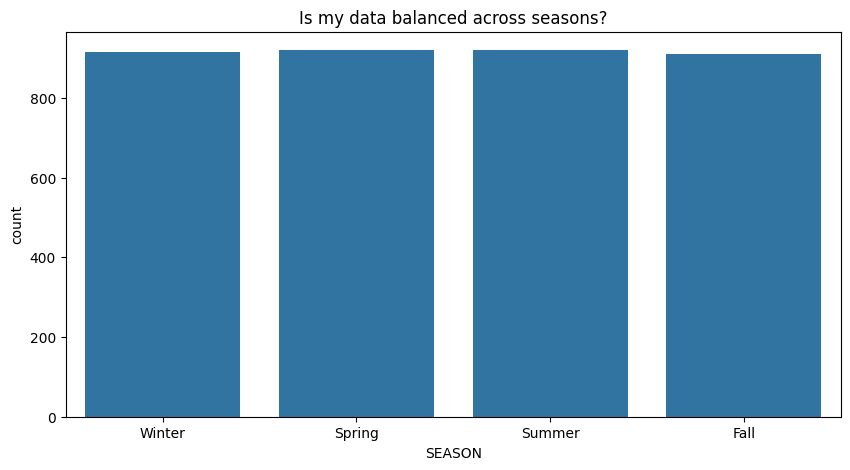

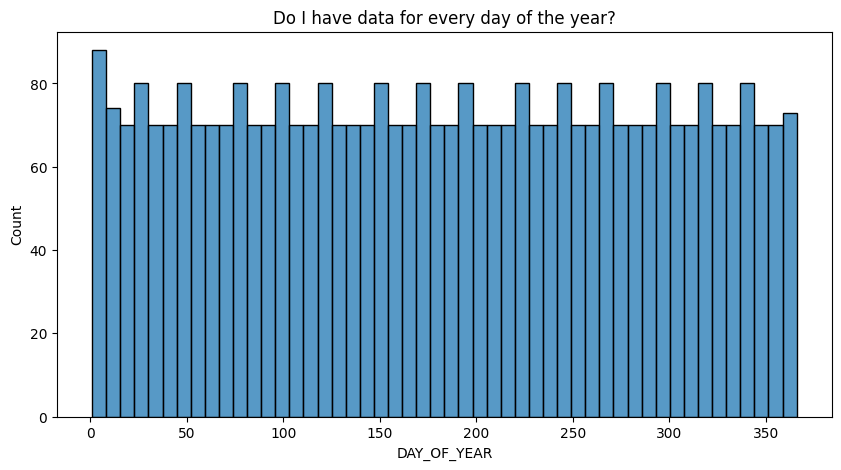

In [ ]:


# 1. Check Seasonality
print(df['SEASON'].value_counts())
plt.figure(figsize=(10, 5))
sns.countplot(x='SEASON', data=df)
plt.title("Is my data balanced across seasons?")
plt.show()

# 2. Check Daily Coverage
plt.figure(figsize=(10, 5))
sns.histplot(x='DAY_OF_YEAR', data=df, bins=50)
plt.title("Do I have data for every day of the year?")
plt.show()



 Representative Sampling: The histograms show a perfectly uniform distribution across DAY_OF_YEAR (0–365) and SEASON. This confirms the dataset covers the full spectrum of annual weather conditions, ensuring the model won't be biased toward specific times of the year (e.g., overfitting to Summer).

  Decide Feature Context: I will treat DAY_OF_YEAR and MONTH as state variables to provide meteorological context. I will apply Cyclical Encoding (Sin/Cos) to these features so the model mathematically understands that Day 365 (Dec 31) is similar to Day 1 (Jan 1), ensuring smooth decision boundaries across the year.

In [ ]:
df['target_int'] = df['FIRE_START_DAY'].astype(int)
cols_to_analyze = [
    'MAX_TEMP', 'MIN_TEMP', 'AVG_WIND_SPEED', 'PRECIPITATION',
    'LAGGED_PRECIPITATION', 'LAGGED_AVG_WIND_SPEED',
    'WIND_TEMP_RATIO', 'TEMP_RANGE', 'DAY_OF_YEAR', 'MONTH',
    'target_int'
]
eda_df = df[cols_to_analyze].dropna()

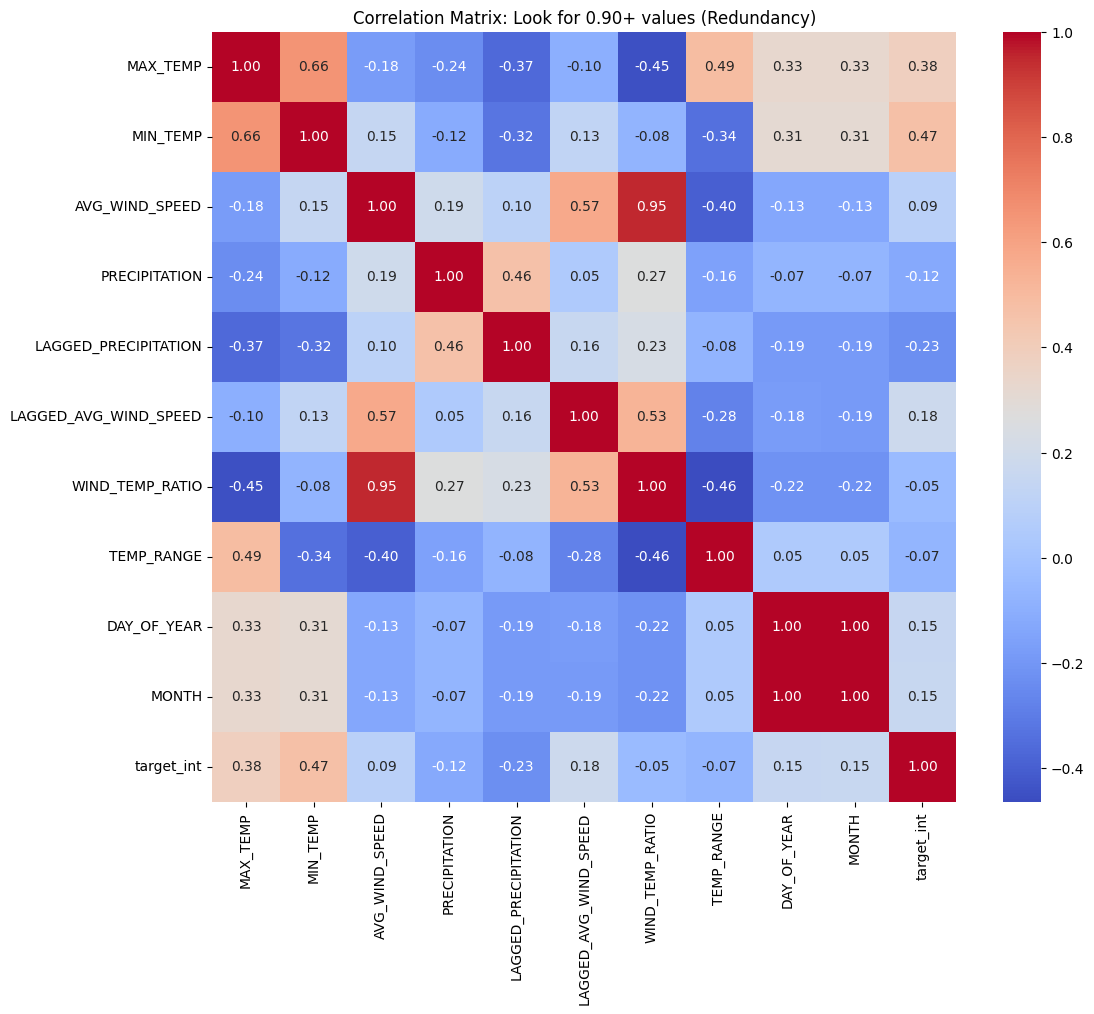

In [ ]:
#REDUNDANCY (Correlation) ---
plt.figure(figsize=(12, 10))

corr = eda_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix: Look for 0.90+ values (Redundancy)")
plt.show()

Document Perfect Redundancy: The features MONTH and DAY_OF_YEAR exhibit a correlation of 1.00. They capture the exact same temporal information, but DAY_OF_YEAR offers higher resolution (365 steps) compared to MONTH (12 steps). Document Derived Feature Risk: WIND_TEMP_RATIO has an extremely high correlation of 0.95 with AVG_WIND_SPEED. This suggests the "Ratio" feature is redundant and acts as a duplicate signal, which can confuse the Neural Network's weight updates. Decide Feature Pruning: I will drop MONTH (keeping DAY_OF_YEAR) and drop WIND_TEMP_RATIO (keeping AVG_WIND_SPEED). Removing these duplicates reduces the input dimension without losing any actual statistical information.

Document Predictor Strength: MIN_TEMP (0.47) is the strongest positive correlate with fire starts, suggesting that high overnight temperatures are a critical risk factor. Additionally, LAGGED_PRECIPITATION (-0.23) is a better predictor than current PRECIPITATION (-0.12), confirming that historical dryness is more important than today's rain.

 Decide Retain Lagged Features: I will explicitly keep the "Lagged" columns in the training set, as the correlation data proves that past weather conditions significantly influence today's fire risk.

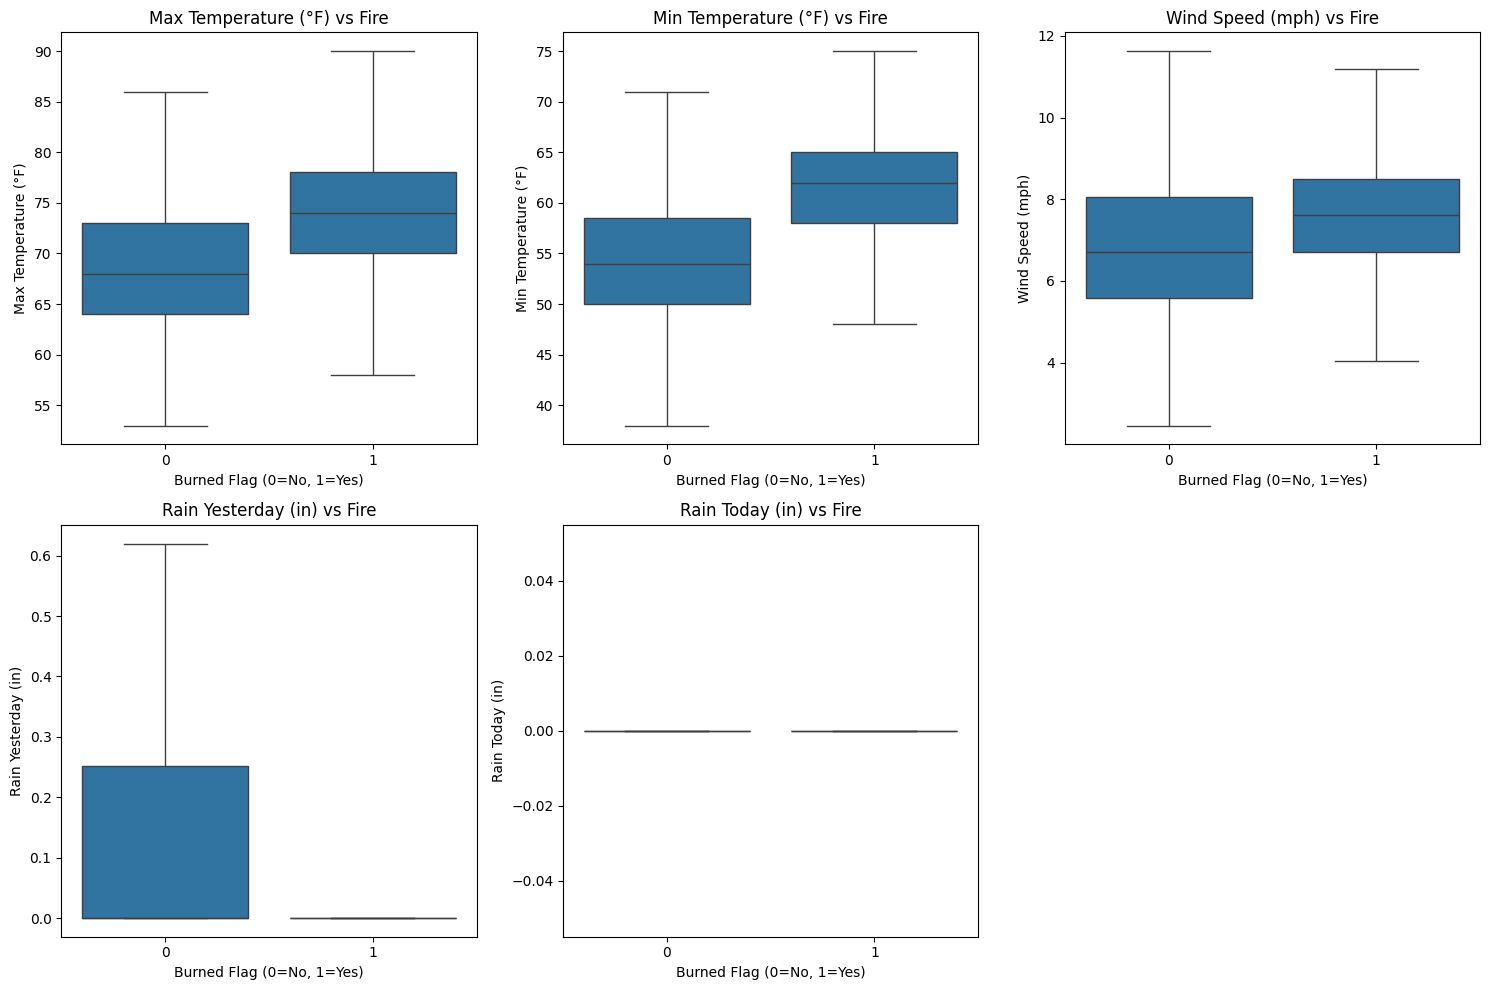

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

variable_names = {
    'MAX_TEMP': 'Max Temperature (°F)',
    'MIN_TEMP': 'Min Temperature (°F)',
    'AVG_WIND_SPEED': 'Wind Speed (mph)',
    'LAGGED_PRECIPITATION': 'Rain Yesterday (in)',
    'PRECIPITATION': 'Rain Today (in)'
}

features = list(variable_names.keys())
n = len(features)
cols = 3
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

for ax, feature in zip(axes, features):
    sns.boxplot(x='target_int', y=feature, data=df, ax=ax, showfliers=False)

    ax.set_title(f"{variable_names[feature]} vs Fire")
    ax.set_xlabel('Burned Flag (0=No, 1=Yes)')
    ax.set_ylabel(variable_names[feature])

for ax in axes[n:]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

 Thermal Separation: MIN_TEMP exhibits the clearest separation between classes, even more so than MAX_TEMP. The median minimum temperature for fire days is roughly 8°F higher than for non-fire days. This suggests that warm nights (indicating a lack of cooling/moisture recovery) are a stronger predictor of fire risk than hot days.

  The "Dryness" Signal: The Rain Yesterday plot reveals a dramatic cutoff. While non-fire days show a spread of rainfall values, the Fire class is compressed entirely at 0.0 inches. This confirms that the absence of recent moisture is a deterministic prerequisite for ignition.
  
  Decide Validate Log-Transform: The Rain Today plot is effectively a flat line for both classes, which visually confirms the "Zero-Inflation" issue. The raw scale fails to show any pattern here, validating my previous decision to apply a Log-Transformation to precipitation features so the model can detect meaningful signals in this sparse data.

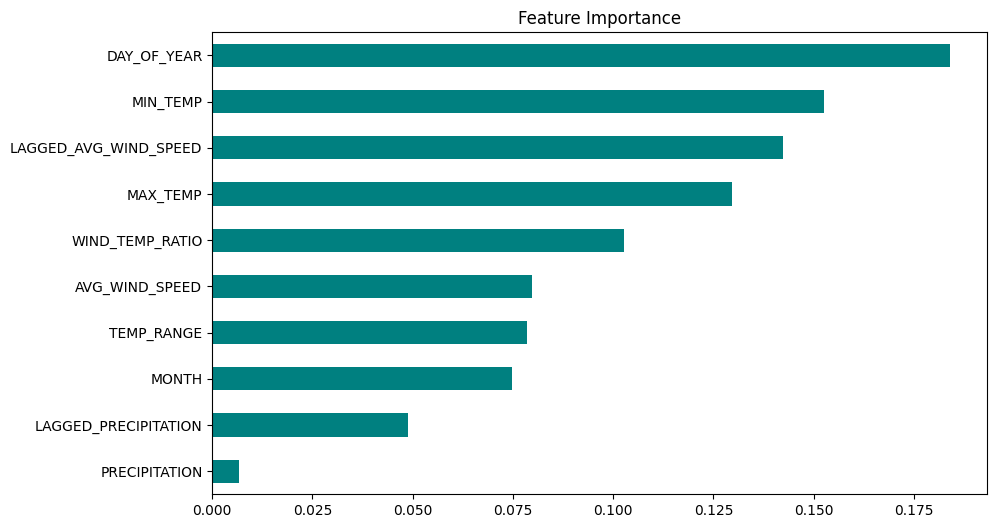

In [ ]:
# (Feature Importance) ---
X = eda_df.drop('target_int', axis=1)
y = eda_df['target_int']

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

plt.figure(figsize=(10, 6))
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', color='teal')
plt.title("Feature Importance")
plt.show()


 Temporal Dominance: DAY_OF_YEAR is the single most predictive feature (Score > 0.175), far outranking specific weather measurements. This confirms that "Seasonality" (the specific time of year) is the primary driver of risk, determining the baseline danger level before daily weather fluctuates.

  The "Lag" Effect: LAGGED_AVG_WIND_SPEED (3rd place) ranks significantly higher than current AVG_WIND_SPEED (6th place). This proves that historical conditions (drying out the vegetation over time) are more critical for ignition potential than the wind speed at the exact moment of the fire.
  
  
  Decide Feature Pruning: PRECIPITATION ranks dead last, likely due to the "Zero-Inflation" issue (it rarely rains on fire days, so the feature is mostly static). I will drop MONTH (low importance and redundant with DAY_OF_YEAR) and WIND_TEMP_RATIO (redundant), but I will keep MIN_TEMP as it surprisingly outperforms MAX_TEMP, confirming that warm nights are a key risk indicator.

--- Fire Probability by Month ---
month_name
Jan    0.071429
Mar    0.135484
Dec    0.138710
Feb    0.141343
Nov    0.230000
Apr    0.250000
Oct    0.451613
May    0.525806
Sep    0.606667
Aug    0.732258
Jun    0.780000
Jul    0.796774
Name: target_int, dtype: float64

--- Fire Probability by Day of Week ---
day_name
Mon    0.388145
Wed    0.397706
Sun    0.402672
Tue    0.405354
Fri    0.406489
Sat    0.416031
Thu    0.419847
Name: target_int, dtype: float64


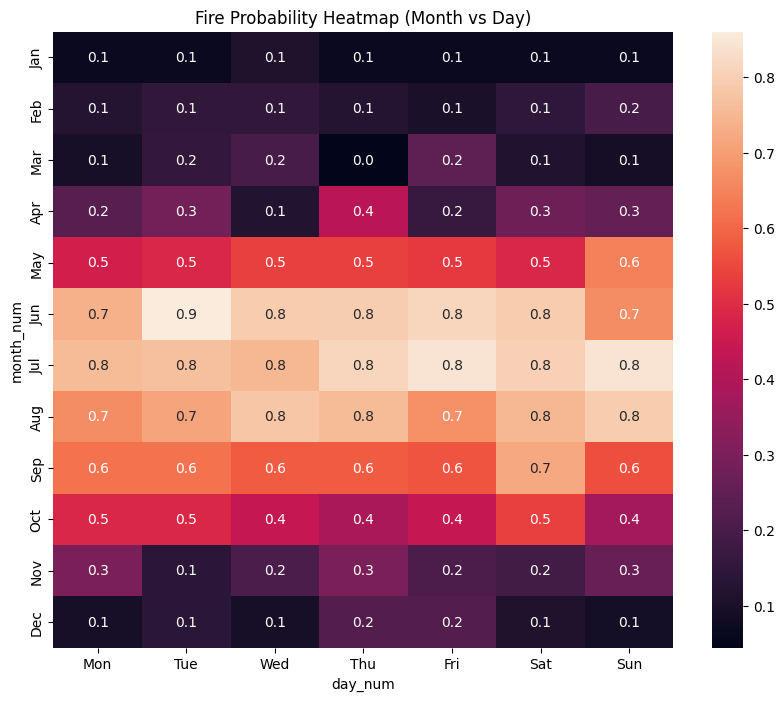

In [ ]:



df_viz = pd.read_csv('CA_Weather_Fire_Dataset.csv')
df_viz = df_viz[df_viz['YEAR'] >= 2015].copy().reset_index(drop=True)

if 'FIRE_START_DAY' in df_viz.columns:
    df_viz['target_int'] = df_viz['FIRE_START_DAY'].astype(int)

# 3. Extract Month and Day of Week
df_viz['DATE'] = pd.to_datetime(df_viz['DATE'])
df_viz['month_name'] = df_viz['DATE'].dt.strftime('%b')
df_viz['day_name'] = df_viz['DATE'].dt.strftime('%a')
df_viz['month_num'] = df_viz['DATE'].dt.month
df_viz['day_num'] = df_viz['DATE'].dt.dayofweek

#  AVERAGES
print("--- Fire Probability by Month ---")
print(df_viz.groupby('month_name')['target_int'].mean().sort_values())

print("\n--- Fire Probability by Day of Week ---")
print(df_viz.groupby('day_name')['target_int'].mean().sort_values())

#HEATMAP ---
# Pivot table
pt = df_viz.pivot_table(index='month_num', columns='day_num', values='target_int', aggfunc='mean')

month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
             7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
day_map = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}

pt.index = pt.index.map(month_map)
pt.columns = pt.columns.map(day_map)

plt.figure(figsize=(10, 8))
sns.heatmap(pt, annot=True, fmt=".1f")
plt.title("Fire Probability Heatmap (Month vs Day)")
plt.show()


 Seasonal Peak: The heatmap confirms a distinct "Fire Season," with probability surging to nearly 90% during the peak summer months (June–July). Conversely, the winter block (Dec–Feb) remains consistently dark/safe (probability < 10%).


  Weekly Irrelevance: There is zero variance across the X-axis (Day of Week). The vertical columns are identical, meaning the probability of a fire is statistically the same on a Monday as it is on a Saturday. This indicates that human weekly cycles (e.g., weekend camping trips) are not a primary driver of ignition in this dataset.
  
   Decide Drop Weekday Features: Since the day of the week provides no signal, I will exclude any "Day of Week" features from the model to prevent noise. The model should focus purely on the annual cycle (DAY_OF_YEAR) rather than the weekly cycle.

##Cleaning the data

In [ ]:
# Drop missing values
df = df.dropna().reset_index(drop=True)

# Log Transformations
df['PRECIPITATION'] = np.log1p(df['PRECIPITATION'])
df['LAGGED_PRECIPITATION'] = np.log1p(df['LAGGED_PRECIPITATION'])
df['AVG_WIND_SPEED'] = np.log1p(df['AVG_WIND_SPEED'])

# Cyclical Encoding
df['DAY_OF_YEAR_SIN'] = np.sin(2 * np.pi * df['DAY_OF_YEAR'] / 365)
df['DAY_OF_YEAR_COS'] = np.cos(2 * np.pi * df['DAY_OF_YEAR'] / 365)

#  Drop Redundant Columns
df = df.drop(columns=['WIND_TEMP_RATIO', 'MONTH', 'DAY_OF_YEAR'])

#  One-Hot Encoding
df = pd.get_dummies(df, columns=['SEASON'], dtype=int)

#turns "True" into 1 and "False" into 0
df['FIRE_START_DAY'] = df['FIRE_START_DAY'].astype(int)

df.to_csv('Processed_Fire_Dataset.csv', index=False)



In [ ]:
df.head()

,PRECIPITATION,MAX_TEMP,MIN_TEMP,AVG_WIND_SPEED,FIRE_START_DAY,TEMP_RANGE,LAGGED_PRECIPITATION,LAGGED_AVG_WIND_SPEED,target_int,DAY_OF_YEAR_SIN,DAY_OF_YEAR_COS,SEASON_Fall,SEASON_Spring,SEASON_Summer,SEASON_Winter
0,0.0,57.0,36.0,1.814825,0,21.0,0.270027,5.527143,0,0.017213,0.999852,0,0,0,1
1,0.0,56.0,38.0,1.658228,0,18.0,0.270027,5.400000,0,0.034422,0.999407,0,0,0,1
2,0.0,59.0,42.0,1.814825,0,17.0,0.270027,5.400000,0,0.051620,0.998667,0,0,0,1
3,0.0,61.0,42.0,1.740466,0,19.0,0.270027,5.400000,0,0.068802,0.997630,0,0,0,1
4,0.0,79.0,50.0,1.885553,0,29.0,0.270027,5.622857,0,0.085965,0.996298,0,0,0,1


#Diabetes dataset

In [ ]:
!pip install ucimlrepo


In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
diabetes = fetch_ucirepo(id=891)

# data (as pandas dataframes)
health_indicators = diabetes.data.features
diabetes_diagnosis = diabetes.data.targets

# metadata
print(diabetes.metadata)

# variable information
print(diabetes.variables)

{'uci_id': 891, 'name': 'CDC Diabetes Health Indicators', 'repository_url': 'https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators', 'data_url': 'https://archive.ics.uci.edu/static/public/891/data.csv', 'abstract': 'The Diabetes Health Indicators Dataset contains healthcare statistics and lifestyle survey information about people in general along with their diagnosis of diabetes. The 35 features consist of some demographics, lab test results, and answers to survey questions for each patient. The target variable for classification is whether a patient has diabetes, is pre-diabetic, or healthy. ', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Tabular', 'Multivariate'], 'num_instances': 253680, 'num_features': 21, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Sex', 'Age', 'Education Level', 'Income'], 'target_col': ['Diabetes_binary'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_

>Peak

In [ ]:
print(health_indicators.shape, health_indicators.columns.tolist())
print(health_indicators.head())

(253680, 21) ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']
   HighBP  HighChol  CholCheck  BMI  Smoker  Stroke  HeartDiseaseorAttack  \
0       1         1          1   40       1       0                     0   
1       0         0          0   25       1       0                     0   
2       1         1          1   28       0       0                     0   
3       1         0          1   27       0       0                     0   
4       1         1          1   24       0       0                     0   

   PhysActivity  Fruits  Veggies  ...  AnyHealthcare  NoDocbcCost  GenHlth  \
0             0       0        1  ...              1            0        5   
1             1       0        0  ...              0            1        3   
2             0       1      

> integrity check

In [ ]:

df = pd.concat([health_indicators, diabetes_diagnosis], axis=1)
#  inspection commands
print("--- DataFrame Info ---")
df.info()

print("\n--- Missing Values ---")
print(df.isna().sum())

print("\n--- Unique Values ---")
print(df.nunique())
print(f"\nDuplicates: {df.duplicated().sum()}")

--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   HighBP                253680 non-null  int64
 1   HighChol              253680 non-null  int64
 2   CholCheck             253680 non-null  int64
 3   BMI                   253680 non-null  int64
 4   Smoker                253680 non-null  int64
 5   Stroke                253680 non-null  int64
 6   HeartDiseaseorAttack  253680 non-null  int64
 7   PhysActivity          253680 non-null  int64
 8   Fruits                253680 non-null  int64
 9   Veggies               253680 non-null  int64
 10  HvyAlcoholConsump     253680 non-null  int64
 11  AnyHealthcare         253680 non-null  int64
 12  NoDocbcCost           253680 non-null  int64
 13  GenHlth               253680 non-null  int64
 14  MentHlth              253680 non-null  int64
 15  PhysHlth   

Document
Data Integrity: The dataset is robust and highly structured, containing 253,680 rows and 22 columns with zero missing values, eliminating the need for imputation.

Data Types: All features are already encoded as integers (int64), meaning no text-to-numeric conversion (e.g., One-Hot Encoding) is required.

Redundancy: There are 24,206 duplicate rows (approx. 9.5% of the data), likely due to distinct individuals giving identical survey responses.

Decide

Investigate Class Balance: Since the dataset is so large, I need to check the ratio of Diabetes_binary (0 vs 1) next. Real-world medical data is often imbalanced, so I will likely need to downsample the majority class.

###  CHECK the Balance of the data


Total Rows: 253680

Class Counts (0 = Healthy, 1 = Diabetic):
Diabetes_binary
0    218334
1     35346
Name: count, dtype: int64

Ratio: 6.2 to 1 (Healthy to Diabetic)


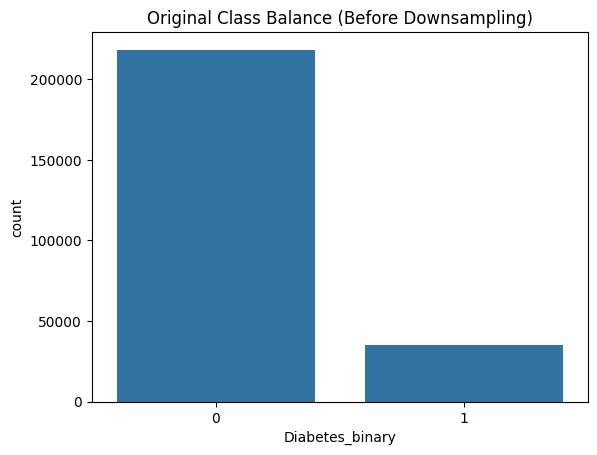

In [ ]:
print(f"Total Rows: {len(df)}")
print("\nClass Counts (0 = Healthy, 1 = Diabetic):")
print(df['Diabetes_binary'].value_counts())

#  Ratio of diabetes
count_0 = df['Diabetes_binary'].value_counts()[0]
count_1 = df['Diabetes_binary'].value_counts()[1]
print(f"\nRatio: {count_0 / count_1:.1f} to 1 (Healthy to Diabetic)")


sns.countplot(x='Diabetes_binary', data=df)
plt.title("Original Class Balance (Before Downsampling)")
plt.show()


Document
Severe Imbalance: The dataset exhibits a significant class imbalance with a ratio of 6.2 to 1 (Healthy vs. Diabetic).

Class Counts: There are 218,334 healthy instances (Class 0) compared to only 35,346 diabetic instances (Class 1).

Majority Bias Risk: Without intervention, a model could achieve ~86% accuracy simply by predicting "Healthy" for every patient, failing to learn any actual symptoms of diabetes.

Decide
Enforce Balancing: I must balance the classes to ensure the Neural Network treats both outcomes equally.

Create 50/50 Split: I will downsample the majority class (Healthy) to match the minority class (Diabetic). Specifically, I will select 2,500 samples from each class to create the final 5,000-row training set.

> Downsampling and balancing the data

In [ ]:
#  Separate Classes
df_0 = df[df['Diabetes_binary'] == 0] # Healthy
df_1 = df[df['Diabetes_binary'] == 1] # Diabetic

# Sample 2,500 from each
df_0_balanced = df_0.sample(n=2500, random_state=42)
df_1_balanced = df_1.sample(n=2500, random_state=42)

#  Combine and Shuffle
df_balanced = pd.concat([df_0_balanced, df_1_balanced])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("\nNew Dataset Shape:", df_balanced.shape)
print("Class Counts:")
print(df_balanced['Diabetes_binary'].value_counts())

df_balanced.to_csv('DiabetesBalanced.csv', index=False)
print("\nSuccess! Saved 'DiabetesBalanced.csv'")


New Dataset Shape: (5000, 22)
Class Counts:
Diabetes_binary
0    2500
1    2500
Name: count, dtype: int64

Success! Saved 'DiabetesBalanced.csv'





Balancing Strategy: I applied random downsampling to create a manageable, balanced subset from the original 253,680 rows. I selected exactly 2,500 healthy and 2,500 diabetic instances.

Final Dataset Structure: The new training set (DiabetesBalanced.csv) contains 5,000 rows and 22 columns.

Class Ratio: The dataset now has a perfect 1:1 ratio (50% Healthy, 50% Diabetic), completely eliminating the previous 6.2:1 imbalance.

##EDA for the data after balancing

In [ ]:
print("Shape:", df_balanced.shape)
print("\nMissing Values:\n", df_balanced.isna().sum().sum())

print(df_balanced['Diabetes_binary'].value_counts(normalize=True))

Shape: (5000, 22)

Missing Values:
 0
Diabetes_binary
0    0.5
1    0.5
Name: proportion, dtype: float64


/tmp/ipython-input-373111868.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Age_Label', data=df_balanced, palette='Blues_d', order=ordered_ages)


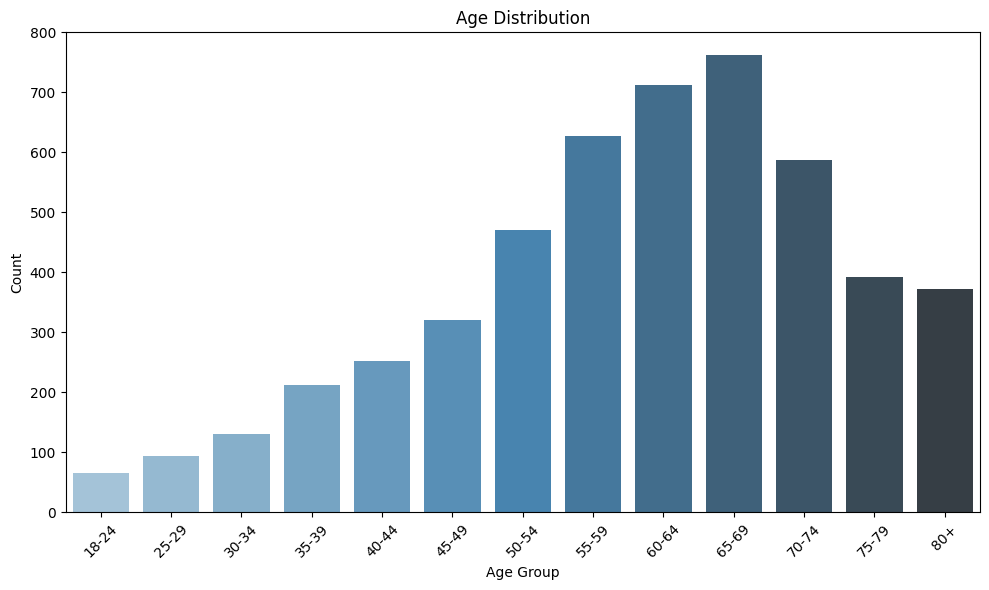

/tmp/ipython-input-373111868.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sex_Label', data=df_balanced, palette='Set2')


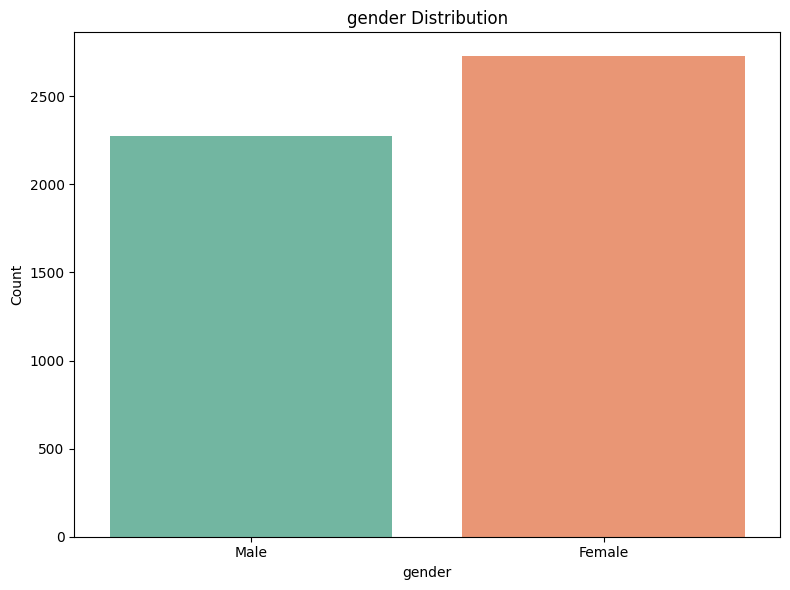

In [ ]:
age_map = {
    1: '18-24', 2: '25-29', 3: '30-34', 4: '35-39', 5: '40-44', 6: '45-49',
    7: '50-54', 8: '55-59', 9: '60-64', 10: '65-69', 11: '70-74', 12: '75-79', 13: '80+'
}
sex_map = {0: 'Female', 1: 'Male'}

df_balanced['Age_Label'] = df_balanced['Age'].map(age_map)
df_balanced['Sex_Label'] = df_balanced['Sex'].map(sex_map)

# --- PLOT  AGE DISTRIBUTION ---
plt.figure(figsize=(10, 6))
ordered_ages = df_balanced.sort_values('Age')['Age_Label'].unique()

sns.countplot(x='Age_Label', data=df_balanced, palette='Blues_d', order=ordered_ages)
plt.title('Age Distribution')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- PLOT  gender DISTRIBUTION ---
plt.figure(figsize=(8, 6))
sns.countplot(x='Sex_Label', data=df_balanced, palette='Set2')
plt.title('gender Distribution')
plt.xlabel('gender')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

 Demographic Split: The gender distribution is relatively balanced, with a slight prevalence of female participants (~2,700) compared to males (~2,300), ensuring the model has sufficient examples to learn patterns for both sexes without requiring rebalancing.

  Age Skew: The dataset is heavily weighted towards older demographics, with the highest concentration of records falling in the 60–69 age range. Conversely, the 18–34 age groups are underrepresented, reflecting the natural prevalence of Type 2 diabetes in older adults.
  
  Decide Note Generalization Limit: I will retain these features as core demographic inputs. However, I will explicitly note that the model's reliability may decrease for young adults (under 30) due to the data sparsity in those specific age brackets.

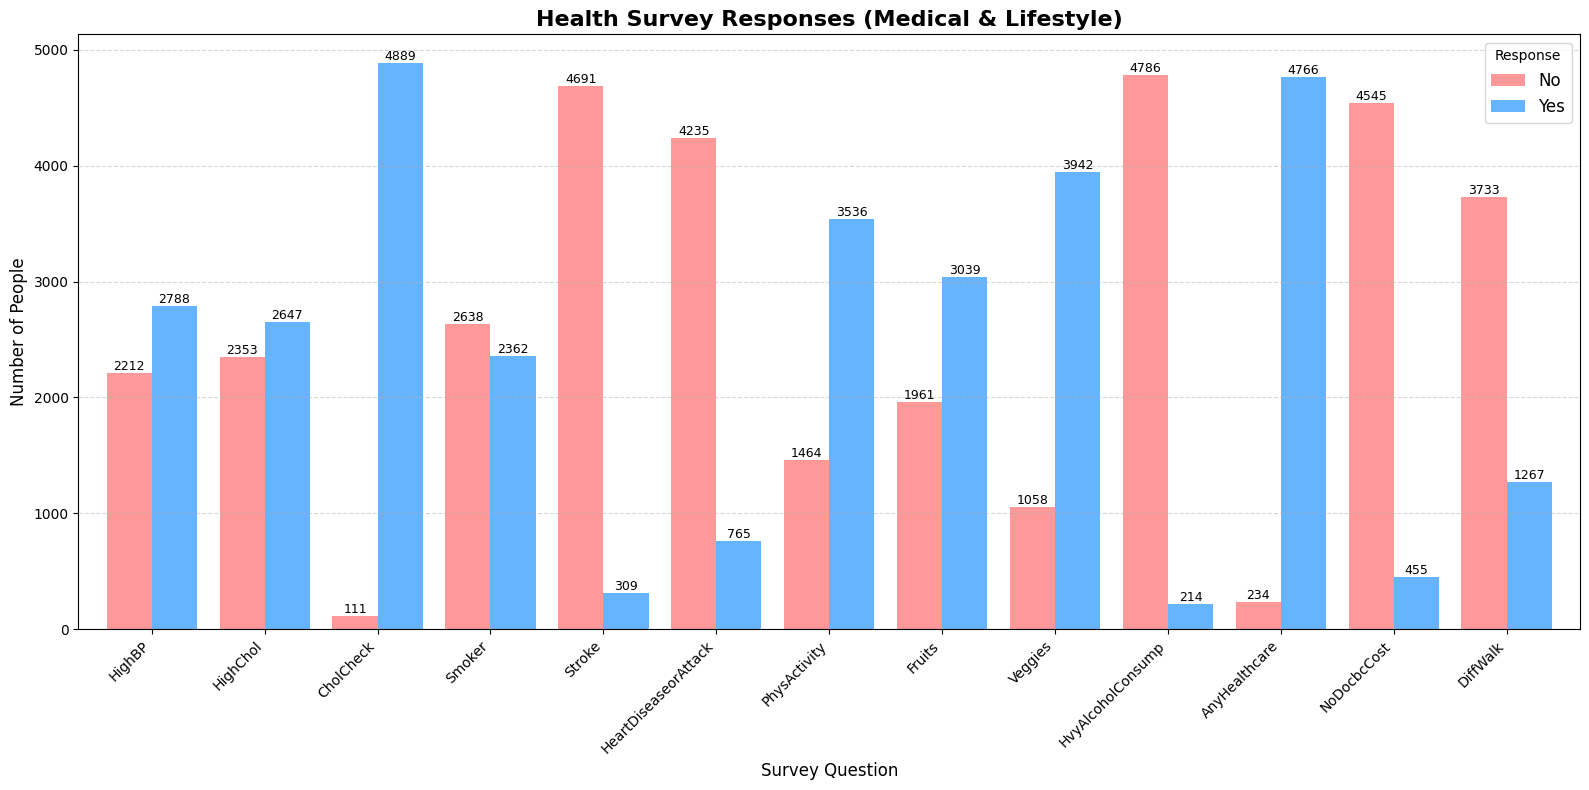

In [ ]:


# features to plot
features = [
    'HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke',
    'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
    'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk'
]

counts_data = []
for col in features:
    val_counts = df_balanced[col].value_counts()
    no_count = val_counts.get(0, 0)
    yes_count = val_counts.get(1, 0)
    counts_data.append({'Feature': col, 'No': no_count, 'Yes': yes_count})

df_counts = pd.DataFrame(counts_data).set_index('Feature')

# 3. Plot
fig, ax = plt.subplots(figsize=(16, 8))
df_counts.plot(kind='bar', ax=ax, color=['#ff9999', '#66b3ff'], width=0.8)

ax.set_title('Health Survey Responses (Medical & Lifestyle)', fontsize=16, fontweight='bold')
ax.set_ylabel('Number of People', fontsize=12)
ax.set_xlabel('Survey Question', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Response', labels=['No', 'Yes'], fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add Labels
for p in ax.patches:
    if p.get_height() > 0:
        ax.annotate(f'{int(p.get_height())}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

 Prevalence Patterns: Common risk factors like HighBP and HighChol are well-represented with significant positive counts, whereas severe events like Stroke and HeartDiseaseorAttack remain rare minorities (approx. 6-15% frequency) even in this sample.

  Low Variance: Features such as CholCheck and AnyHealthcare exhibit extreme skewness (over 95%), indicating that nearly all participants—regardless of diabetic status—have access to basic diagnostics.
  
  Decide Monitor Feature Utility: I will proceed with training using all lifestyle inputs, but I will closely evaluate the low-variance features (CholCheck, AnyHealthcare) during the Feature Importance phase. If they fail to provide distinct signals, I will remove them to reduce model noise.

/tmp/ipython-input-3861678125.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Diabetes_binary', y=feature, data=df_balanced, ax=axes[i], palette="Set2")
/tmp/ipython-input-3861678125.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Diabetes_binary', y=feature, data=df_balanced, ax=axes[i], palette="Set2")
/tmp/ipython-input-3861678125.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Diabetes_binary', y=feature, data=df_balanced, ax=axes[i], palette="Set2")
/tmp/ipython-input-3861678125.py:14: FutureWarning: 

Passing `p

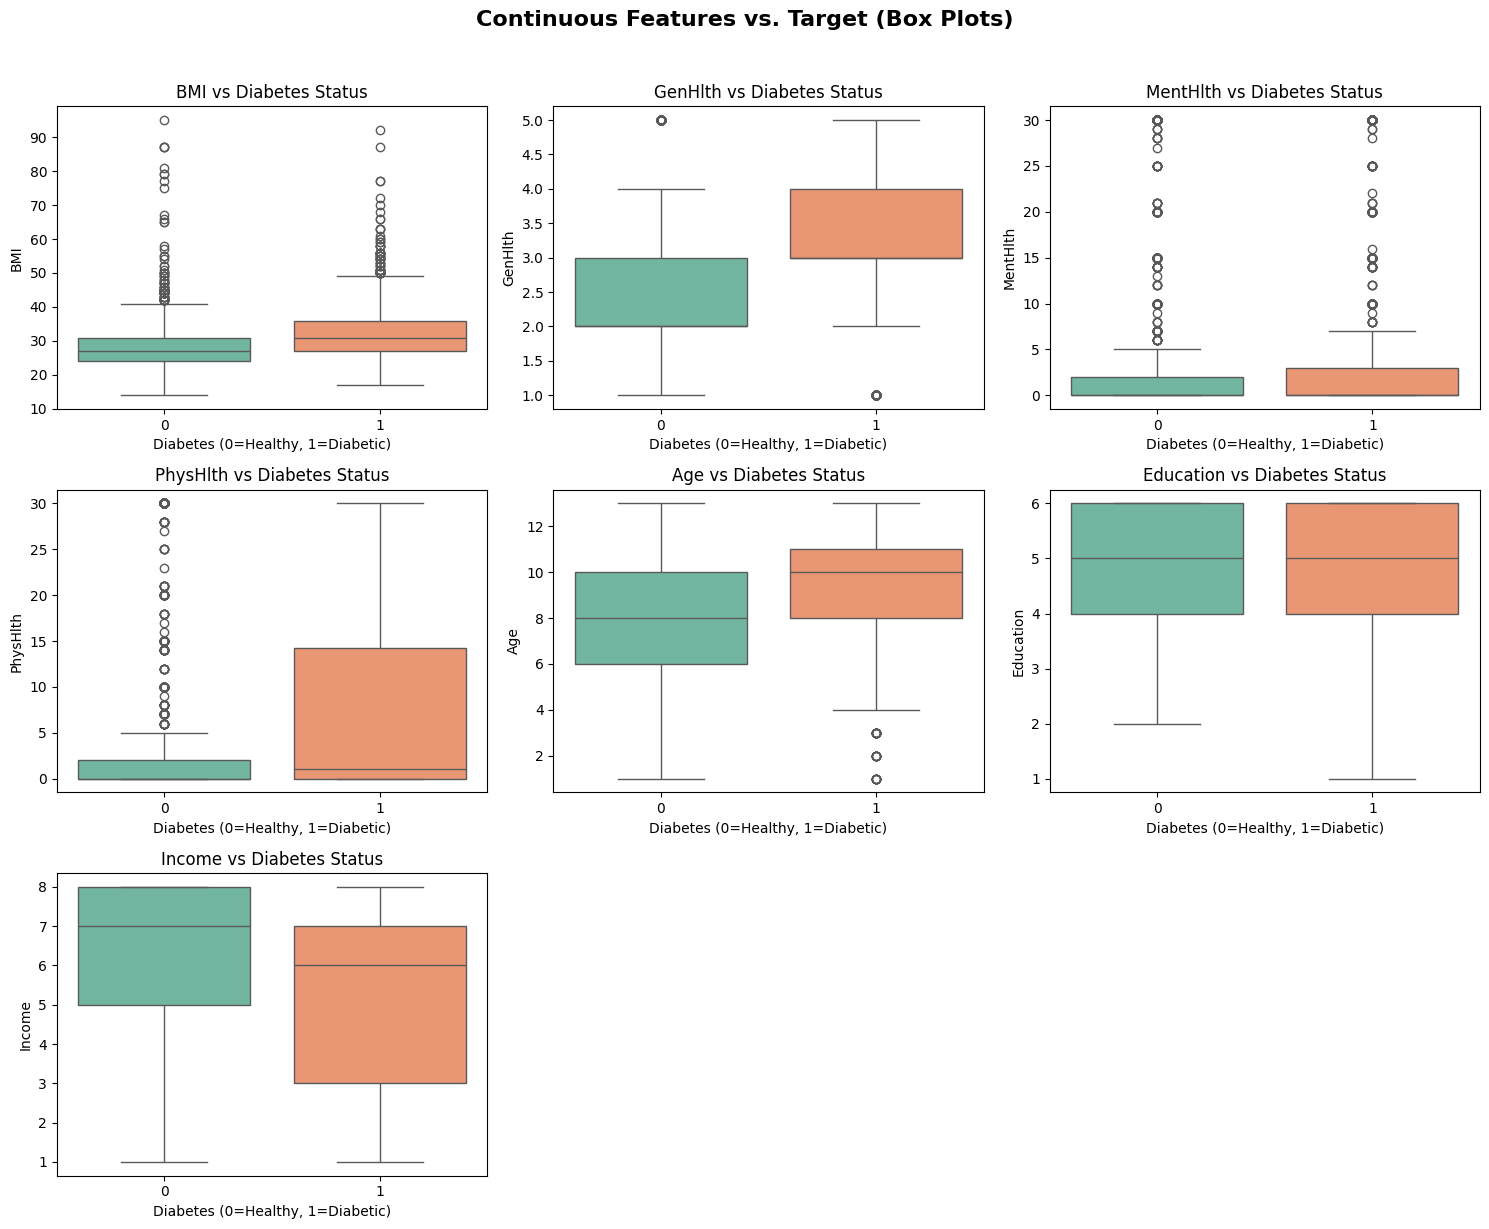

In [ ]:

continuous_features = ['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']

n_cols = 3
n_rows = (len(continuous_features) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, feature in enumerate(continuous_features):
    sns.boxplot(x='Diabetes_binary', y=feature, data=df_balanced, ax=axes[i], palette="Set2")
    axes[i].set_title(f'{feature} vs Diabetes Status')
    axes[i].set_xlabel('Diabetes (0=Healthy, 1=Diabetic)')

# Remove empty subplots
for i in range(len(continuous_features), len(axes)):
    fig.delaxes(axes[i])

plt.suptitle("Continuous Features vs. Target (Box Plots)", y=1.02, fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

 Strong Predictors: The GenHlth and Age features show the strongest separation between classes. Diabetic patients (Class 1) consistently report much poorer general health (median level 4 vs. 2) and belong to significantly older age groups compared to healthy individuals.

  Socioeconomic Trends: There is a visible inverse relationship with Income; the diabetic group distribution is shifted towards lower income levels (median ~6) compared to the healthy group (median ~7), indicating socioeconomic status is a relevant risk factor.
  
  Decide Feature Strategy: While BMI, GenHlth, and Age provide clear signals, features like Education and MentHlth show significant overlap (low separability). I will include them in the initial training but mark them as candidates for removal if their feature importance scores are low.

/tmp/ipython-input-1565708353.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature, y='Diabetes_binary', data=prob_df, ax=axes[i], palette="coolwarm")
/tmp/ipython-input-1565708353.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature, y='Diabetes_binary', data=prob_df, ax=axes[i], palette="coolwarm")
/tmp/ipython-input-1565708353.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature, y='Diabetes_binary', data=prob_df, ax=axes[i], palette="coolwarm")
/tmp/ipython-input-1565708353.py:19: FutureWarning: 

Passing `p

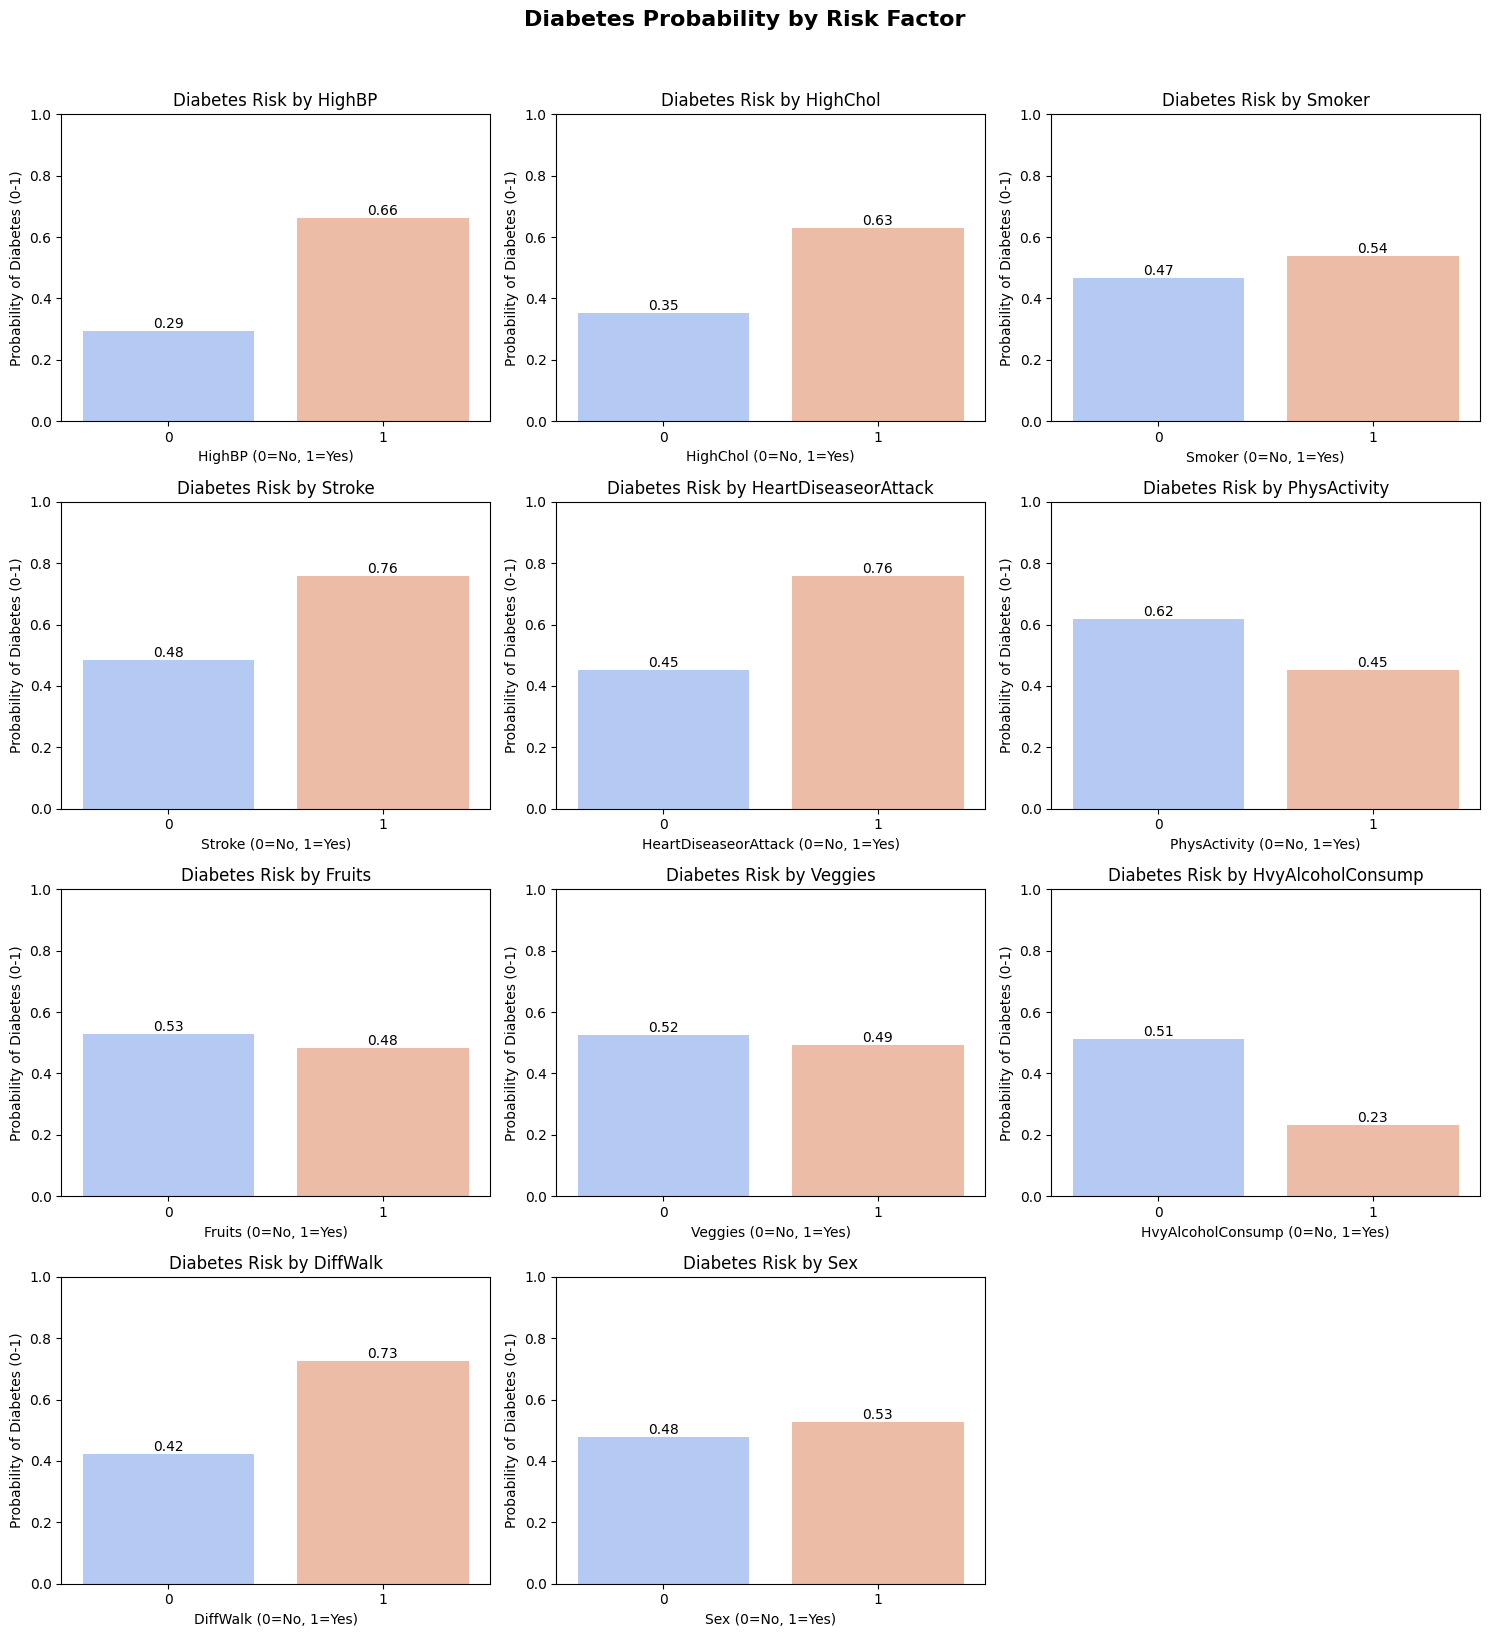

In [ ]:

binary_features = [
    'HighBP', 'HighChol', 'Smoker', 'Stroke', 'HeartDiseaseorAttack',
    'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'DiffWalk', 'Sex'
]

n_cols = 3
n_rows = (len(binary_features) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, feature in enumerate(binary_features):
    # Calculate the % of Diabetics for each group (0 and 1)
    # Group by Feature -> Calculate Mean of Target (0/1)
    prob_df = df_balanced.groupby(feature)['Diabetes_binary'].mean().reset_index()

    sns.barplot(x=feature, y='Diabetes_binary', data=prob_df, ax=axes[i], palette="coolwarm")
    axes[i].set_title(f'Diabetes Risk by {feature}')
    axes[i].set_ylabel('Probability of Diabetes (0-1)')
    axes[i].set_xlabel(f'{feature} (0=No, 1=Yes)')
    axes[i].set_ylim(0, 1.0)


    for p in axes[i].patches:
        axes[i].annotate(f'{p.get_height():.2f}',
                         (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='bottom')

# Remove empty subplots
for i in range(len(binary_features), len(axes)):
    fig.delaxes(axes[i])

plt.suptitle("Diabetes Probability by Risk Factor", y=1.02, fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


 Key Risk Drivers: The features HighBP, HighChol, DiffWalk, Stroke, and HeartDiseaseorAttack exhibit the strongest predictive power, with the probability of diabetes jumping by roughly 30–35% when these conditions are present.

   Counter-Intuitive Correlations: Surprisingly, HvyAlcoholConsump shows an inverse relationship (lower risk for heavy drinkers), likely indicating a confounding variable (e.g., diagnosed patients stopping drinking). Additionally, dietary factors (Fruits, Veggies) show negligible impact on probability separation.
   
   Decide Prioritize Medical Features: I will assign higher importance to the medical history features (HighBP, HighChol) over lifestyle inputs (Fruits, Veggies) during model tuning. I will also isolate the HvyAlcoholConsump feature to test if removing it improves model logic, given its anomalous trend.

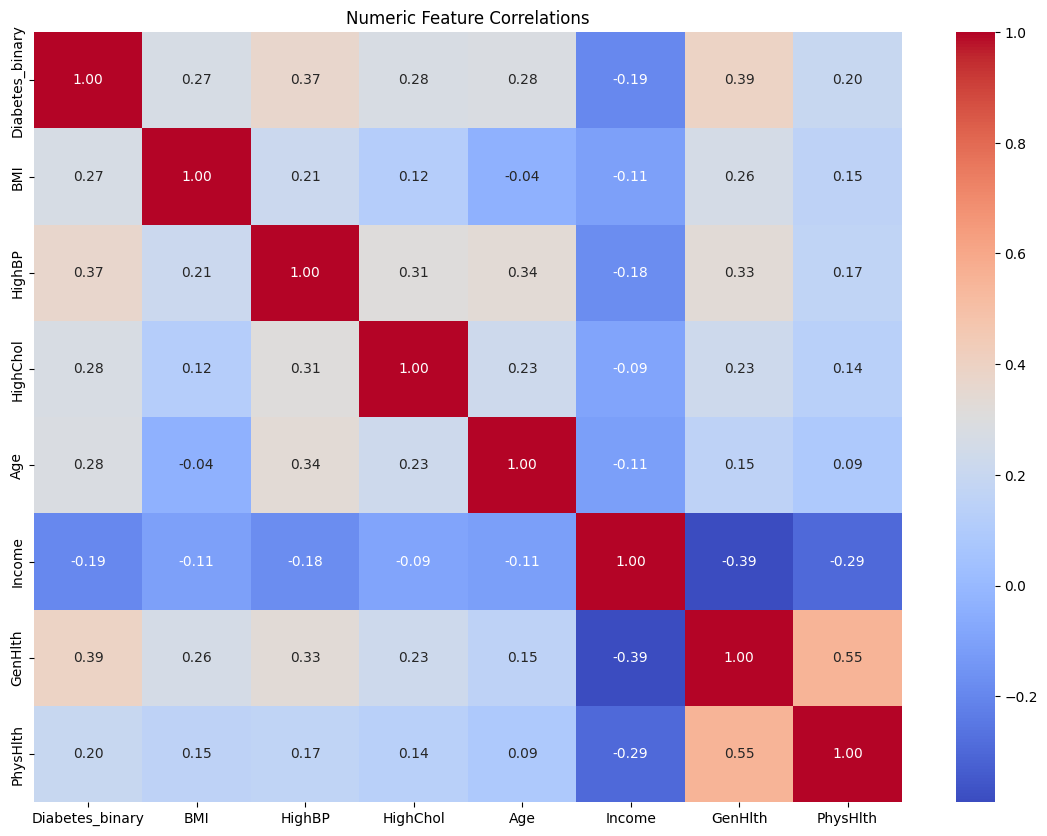

In [ ]:
#  CORRELATION matrix ---
plt.figure(figsize=(14, 10))
cols_to_corr = ['Diabetes_binary', 'BMI', 'HighBP', 'HighChol', 'Age', 'Income', 'GenHlth', 'PhysHlth']
sns.heatmap(df_balanced[cols_to_corr].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Numeric Feature Correlations')
plt.show()

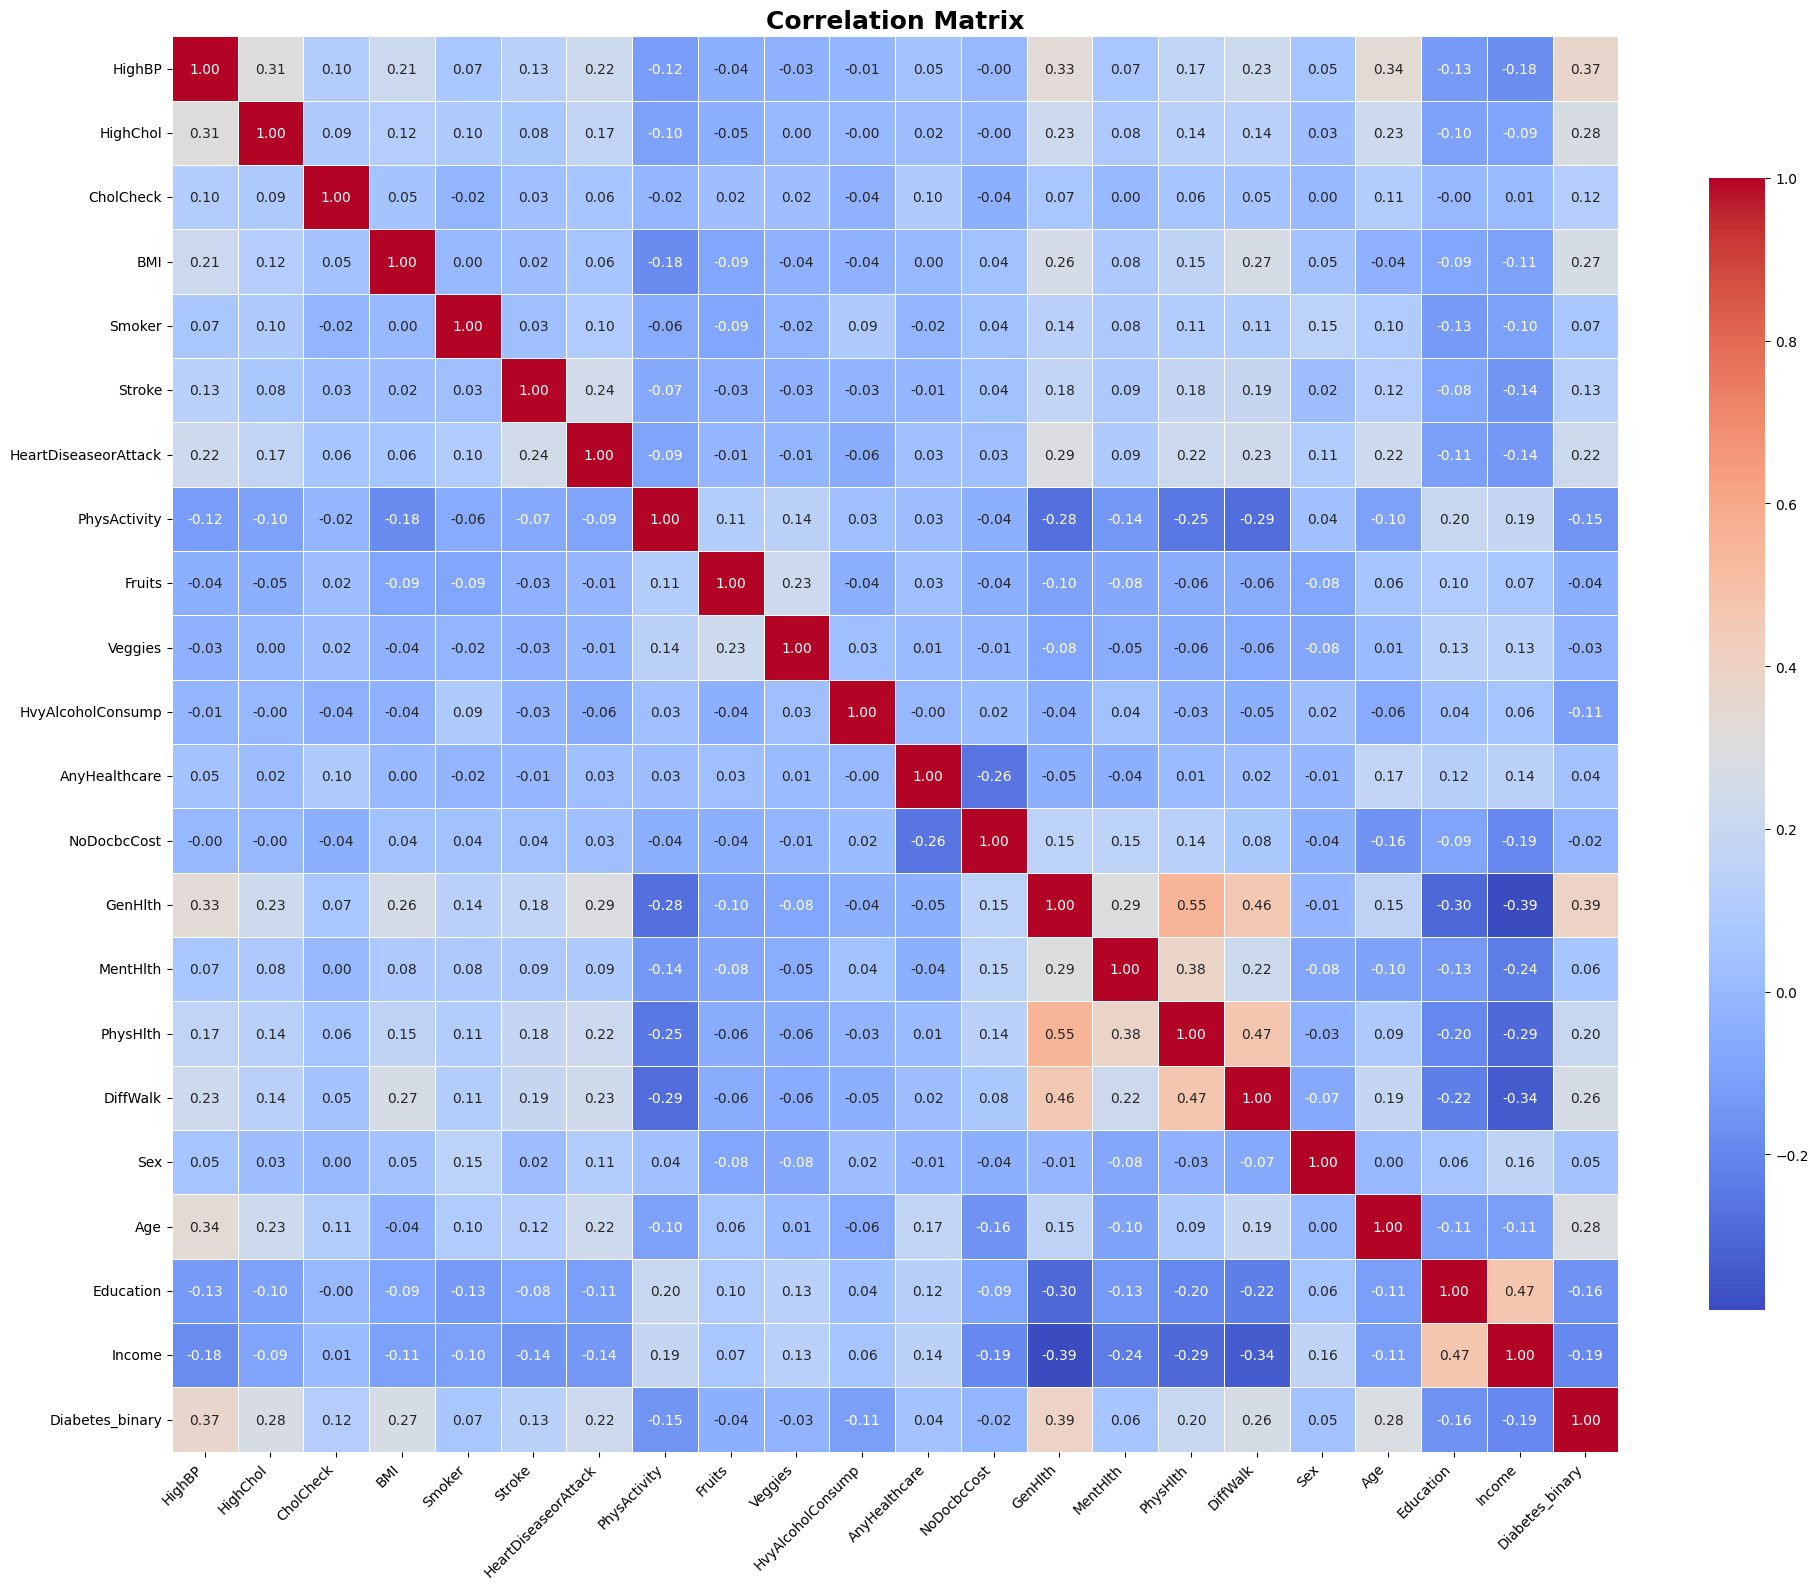

In [ ]:
df_balanced = pd.read_csv("DiabetesBalanced.csv")

corr_matrix = df_balanced.corr()

plt.figure(figsize=(20, 16))

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    linewidths=0.5,
    cbar_kws={"shrink": .8}
)

plt.title('Correlation Matrix', fontsize=18, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Based on the correlation heatmap provided, here is the documentation using the requested layout:

 Top Predictors: The heatmap confirms that GenHlth (0.39) and HighBP (0.37) have the strongest positive correlations with the target variable, indicating that self-reported general health and hypertension history are the most reliable indicators for the model.
  Feature Relationships: There is a moderate correlation (0.55) between GenHlth and PhysHlth, suggesting that as general health worsens, the number of poor physical health days naturally increases, which creates potential redundancy.
  
  Decide Manage Multicollinearity: Since the correlation between GenHlth and PhysHlth is significant but below the typical removal threshold (0.70+), I will retain both features. However, I will use regularization (L2) during training to prevent the model from overfitting on these overlapping signals.

/tmp/ipython-input-1786532758.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=rf_importance_df, palette='viridis')


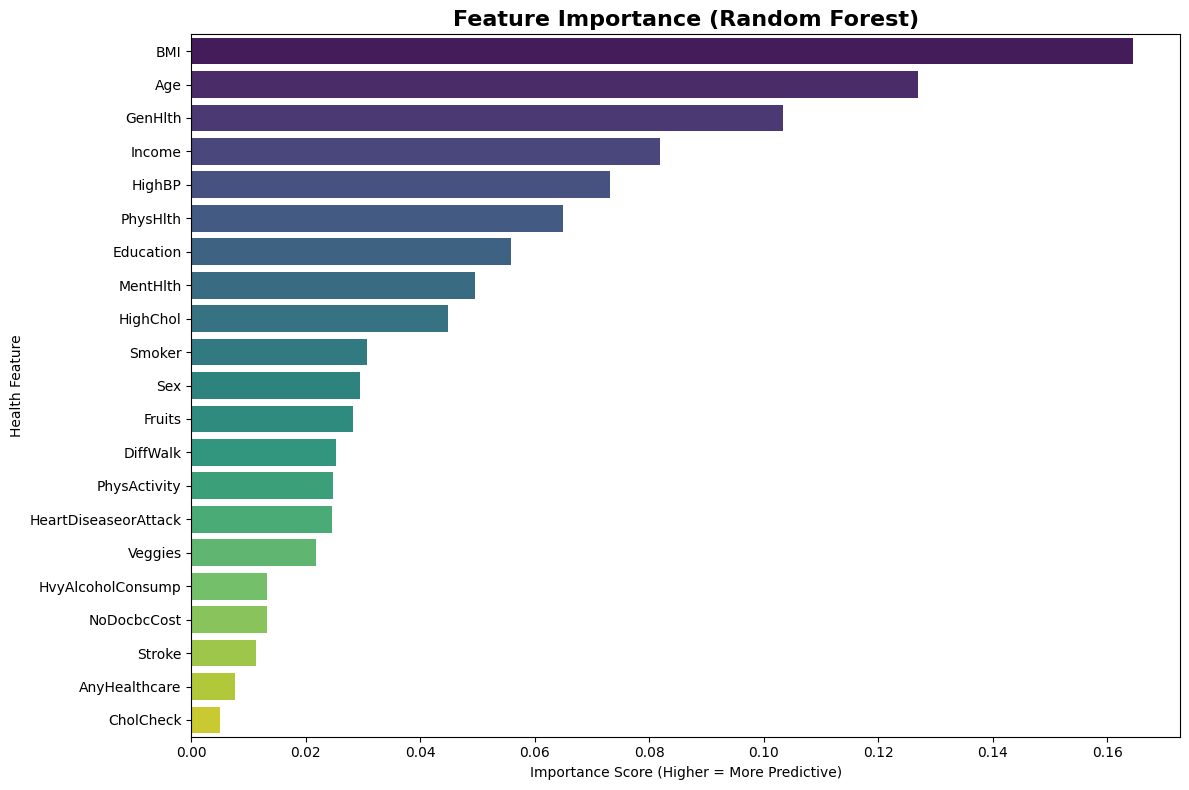


--- Top 5 Key Predictors ---
| Feature   |   Importance |
|:----------|-------------:|
| BMI       |    0.164481  |
| Age       |    0.126904  |
| GenHlth   |    0.103347  |
| Income    |    0.0819382 |
| HighBP    |    0.0731937 |


In [ ]:
X = df_balanced.drop(columns=['Diabetes_binary'])
y = df_balanced['Diabetes_binary']


rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

importances = rf.feature_importances_
feature_names = X.columns

rf_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })

rf_importance_df = rf_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=rf_importance_df, palette='viridis')

plt.title('Feature Importance (Random Forest)', fontsize=16, fontweight='bold')
plt.xlabel('Importance Score (Higher = More Predictive)')
plt.ylabel('Health Feature')
plt.tight_layout()
plt.show()

print("\n--- Top 5 Key Predictors ---")
print(rf_importance_df.head(5).to_markdown(index=False))

 Dominant Predictors: BMI is the single most critical driver for the model (importance score > 0.16), followed closely by Age and GenHlth. Together, these three features account for a significant portion of the model's predictive power, far outweighing lifestyle choices like diet or smoking.  Low-Utility Features: As suspected during the initial data audit, CholCheck and AnyHealthcare rank at the very bottom with near-zero importance. Their lack of variance (almost everyone said "Yes") prevents the model from using them to effectively distinguish between healthy and diabetic patients.

 Decide Prune Input Space: To reduce noise and computational cost, I will drop the bottom 5 features (starting from CholCheck up to HvyAlcoholConsump) before training the final Neural Network, focusing the model exclusively on the high-signal predictors.

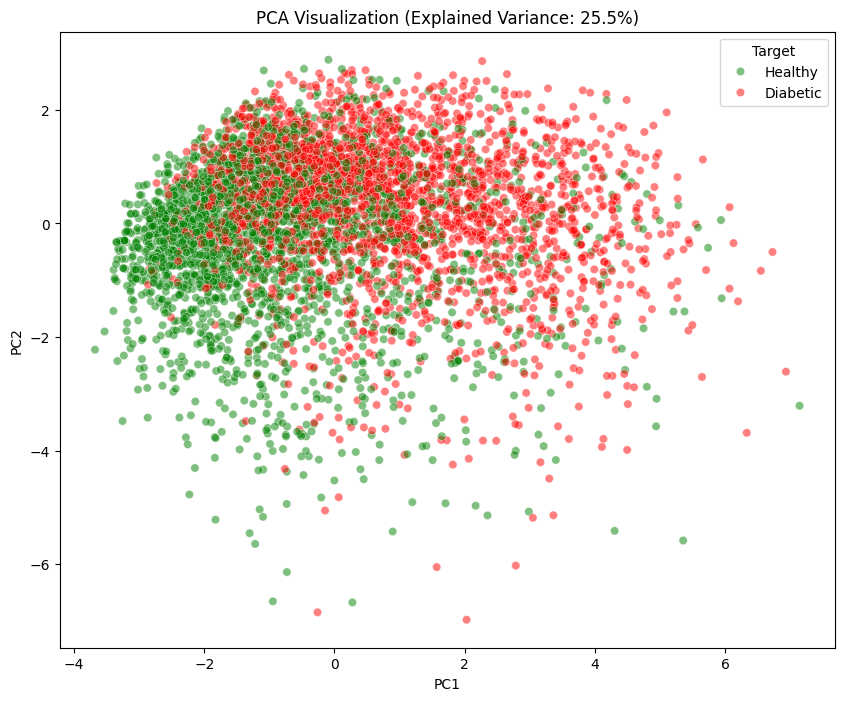

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
X = df_balanced.drop(columns=['Diabetes_binary'])
y = df_balanced['Diabetes_binary']
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
df_pca['Target'] = y.map({0: 'Healthy', 1: 'Diabetic'})

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Target', data=df_pca, alpha=0.5, palette={'Healthy': 'green', 'Diabetic': 'red'})
plt.title(f'PCA Visualization (Explained Variance: {sum(pca.explained_variance_ratio_):.1%})')
plt.show()

 Partial Separability: The visualization reveals a recognizable gradient where Healthy instances (green) cluster towards the negative side of PC1 and Diabetic instances (red) shift towards the positive side. However, the significant overlap confirms that the data is not linearly separable in low dimensions.

  Information Loss: The first two principal components capture only 25.5% of the total variance. This low percentage indicates that the dataset is highly complex and multidimensional, meaning nearly 75% of the statistical information is lost when compressing the data into just two dimensions.
  
  
  Decide Reject PCA for Training: Given the low explained variance and heavy class overlap, I will not use PCA as a preprocessing step for the final model. Instead, I will feed the full set of original features into the Neural Network, relying on its non-linear hidden layers to capture the complex patterns that PCA failed to isolate.

/tmp/ipython-input-3427155578.py:8: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df_balanced.pivot_table(index='Age', columns='BMI_Group', values='Diabetes_binary', aggfunc='mean')


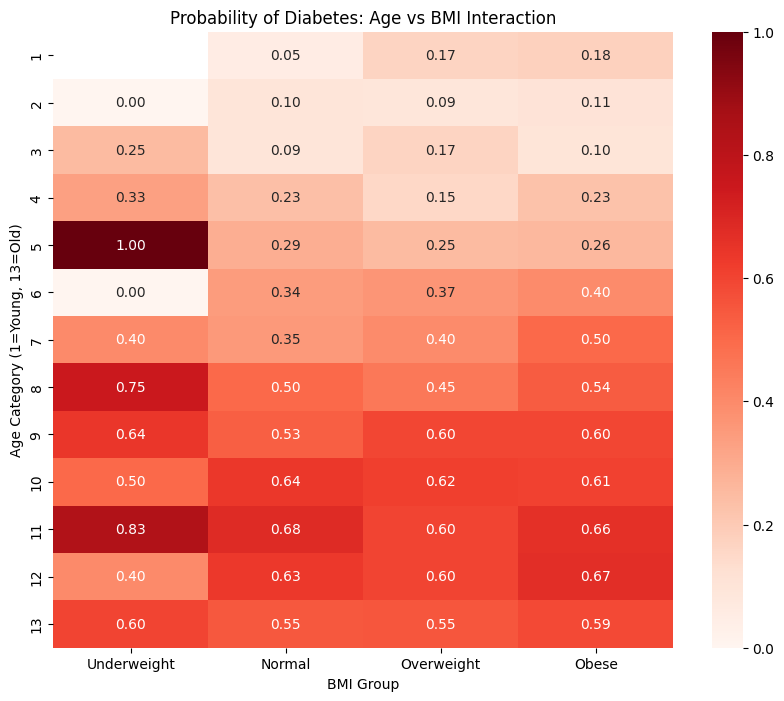

In [ ]:

df_balanced['BMI_Group'] = pd.cut(df['BMI'], bins=[0, 18.5, 25, 30, 100], labels=['Underweight', 'Normal', 'Overweight', 'Obese'])


pivot = df_balanced.pivot_table(index='Age', columns='BMI_Group', values='Diabetes_binary', aggfunc='mean')

plt.figure(figsize=(10, 8))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap='Reds')
plt.title('Probability of Diabetes: Age vs BMI Interaction')
plt.xlabel('BMI Group')
plt.ylabel('Age Category (1=Young, 13=Old)')
plt.show()

 Synergistic Effect: The heatmap confirms that risk factors compound each other; the highest probability of diabetes (>60%) is consistently found in the bottom-right quadrant, representing patients who are both older (Age 10+) and Obese.

  Statistical Noise: The "Underweight" column exhibits extreme volatility, jumping erratically from 0% to 100% (see Age 5). This is a classic indicator of data sparsity (insufficient sample size), making predictions for underweight individuals statistically unreliable compared to the stable trends in the Overweight/Obese columns.
  
   Decide Trust Generalization: I will ignore the anomalous spikes in the "Underweight" category as outliers. Instead of creating manual rules, I will feed Age and BMI as separate inputs and allow the Neural Network to learn the stable non-linear interaction shown in the heavier weight classes.

##Data cleaning

In [ ]:


df = pd.read_csv('DiabetesBalanced.csv')
print(f"Loaded Dataset Shape: {df.shape}")

# Pruning Low-Utility Features ---
cols_to_drop = [
    'CholCheck',         
    'AnyHealthcare',      
    'Stroke',             # Low importance in Random Forest
    'NoDocbcCost',        # Low importance
    'HvyAlcoholConsump'   # Confusing inverse correlation (noise)
]

df = df.drop(columns=cols_to_drop, errors='ignore')
print(f"Dropped {len(cols_to_drop)} columns. New Shape: {df.shape}")

# Scaling Continuous Features ---

cols_to_scale = ['BMI', 'MentHlth', 'PhysHlth', 'GenHlth', 'Age', 'Education', 'Income']

scaler = StandardScaler()
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

df.to_csv('Processed_Diabetes_dataset.csv', index=False)

print("\nProcessing Complete!")
print(df.head())

Loaded Dataset Shape: (5000, 22)
Dropped 5 columns. New Shape: (5000, 17)

Processing Complete!
File 'Diabetes_MLP_Ready.csv' is ready for the Neural Network.
   HighBP  HighChol       BMI  Smoker  HeartDiseaseorAttack  PhysActivity  \
0       1         1  0.276799       1                     0             1   
1       0         1  0.007014       0                     0             0   
2       0         0  0.007014       1                     0             1   
3       1         1  0.411691       0                     1             1   
4       0         0 -0.397663       1                     0             0   

   Fruits  Veggies   GenHlth  MentHlth  PhysHlth  DiffWalk  Sex       Age  \
0       1        1  1.949257  0.774313  0.410312         1    1 -0.215458   
1       0        0 -1.650146 -0.461701 -0.577630         0    0  0.491192   
2       1        0  0.149555 -0.461701 -0.577630         0    0 -0.568783   
3       1        1  0.149555  0.156306 -0.083659         1    0  0.491